<a href="https://colab.research.google.com/github/UdayMekaa/United-States-Measles-Vaccination-Analysis/blob/main/US_Measles_Vaccination_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import math

In [ ]:

df = pd.read_csv("/content/all-measles-rates.csv")

In [ ]:
# 1. Peek at the first few rows
df.head()

,index,state,year,name,type,city,county,district,enroll,mmr,overall,xrel,xmed,xper
0,1,Arizona,2018-19,A J Mitchell Elementary,Public,Nogales,Santa Cruz,NaN,51.0,100.0,-1.0,NaN,NaN,NaN
1,2,Arizona,2018-19,Academy Del Sol,Charter,Tucson,Pima,NaN,22.0,100.0,-1.0,NaN,NaN,NaN
2,3,Arizona,2018-19,Academy Del Sol - Hope,Charter,Tucson,Pima,NaN,85.0,100.0,-1.0,NaN,NaN,NaN
3,4,Arizona,2018-19,Academy Of Mathematics And Science South,Charter,Phoenix,Maricopa,NaN,60.0,100.0,-1.0,NaN,NaN,NaN
4,5,Arizona,2018-19,Acclaim Academy,Charter,Phoenix,Maricopa,NaN,43.0,100.0,-1.0,NaN,2.33,2.33


In [ ]:
# 2. Check the column names
df.columns

Index(['index', 'state', 'year', 'name', 'type', 'city', 'county', 'district',
       'enroll', 'mmr', 'overall', 'xrel', 'xmed', 'xper'],
      dtype='object')

In [ ]:

# 3. Basic dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46411 entries, 0 to 46410
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     46411 non-null  int64  
 1   state     46411 non-null  object 
 2   year      41730 non-null  object 
 3   name      46411 non-null  object 
 4   type      19237 non-null  object 
 5   city      29072 non-null  object 
 6   county    41253 non-null  object 
 7   district  7402 non-null   object 
 8   enroll    33567 non-null  float64
 9   mmr       46411 non-null  float64
 10  overall   46411 non-null  float64
 11  xrel      12141 non-null  float64
 12  xmed      12972 non-null  float64
 13  xper      6411 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 5.0+ MB


In [ ]:
# 4. Count missing values in each column
print(df.isna().sum())

index           0
state           0
year         4681
name            0
type        27174
city        17339
county       5158
district    39009
enroll      12844
mmr             0
overall         0
xrel        34270
xmed        33439
xper        40000
dtype: int64


In [ ]:
# Drop index column
df = df.drop(columns=["index"])

In [ ]:
# Convert percentage strings to floats
df["mmr"] = pd.to_numeric(df["mmr"], errors="coerce")
df["overall"] = pd.to_numeric(df["overall"], errors="coerce")

In [ ]:
# Replace missing types with 'Unknown'
df["type"] = df["type"].fillna("Unknown")

In [ ]:
# Group by type and calculate average rates
type_rates = (
    df.groupby("type")
      .agg(
          overall_mean=("overall", "mean"),
          mmr_mean=("mmr", "mean"),
          count=("overall", "count")
      )
      .sort_values("overall_mean", ascending=False)
)

# Show top 10
type_rates.head(10)


,overall_mean,mmr_mean,count
type,,,
Kindergarten,87.811782,94.262028,1302
Unknown,55.141804,40.356365,27174
Public,53.312202,89.412972,12539
Private,22.959273,58.683153,4910
BOCES,-1.000000,98.753191,47
Charter,-1.000000,68.598095,273
Nonpublic,-1.000000,9.342349,166


*we’ve uncovered some data quality issues mixed in with the rankings.*


**Kindergarten:**
* Highest true overall_mean (87.8%) and strong mmr_mean (94.3%).

* Likely a valid top performer.

**Unknown:**

* Big chunk of data (27k schools) but low overall_mean (55.1%) and very low mmr_mean (40.4%) — possibly incomplete or misclassified.

**Public**

* Low overall_mean (53.3%) but quite high mmr_mean (89.4%) — suggests missing or inaccurate overall values.

**Private**

* Very low overall_mean (22.9%), which seems suspicious — may have a lot of missing overall data or bad entries.

**BOCES / Charter / Nonpublic**

* overall_mean = -1.000000 means these weren’t reported properly — these rows should be cleaned or excluded.



In [ ]:
# Remove invalid overall values
df = df[df["overall"] >= 0]

# Regroup after cleaning
type_rates_clean = (
    df.groupby("type")
      .agg(
          overall_mean=("overall", "mean"),
          mmr_mean=("mmr", "mean"),
          count=("overall", "count")
      )
      .query("count >= 50")  # keep only larger groups
      .sort_values("overall_mean", ascending=False)
)

type_rates_clean

,overall_mean,mmr_mean,count
type,,,
Public,93.154666,94.798617,7233
Unknown,91.961877,12.622175,16411
Private,90.052655,92.179938,1292
Kindergarten,88.085470,94.399969,1298


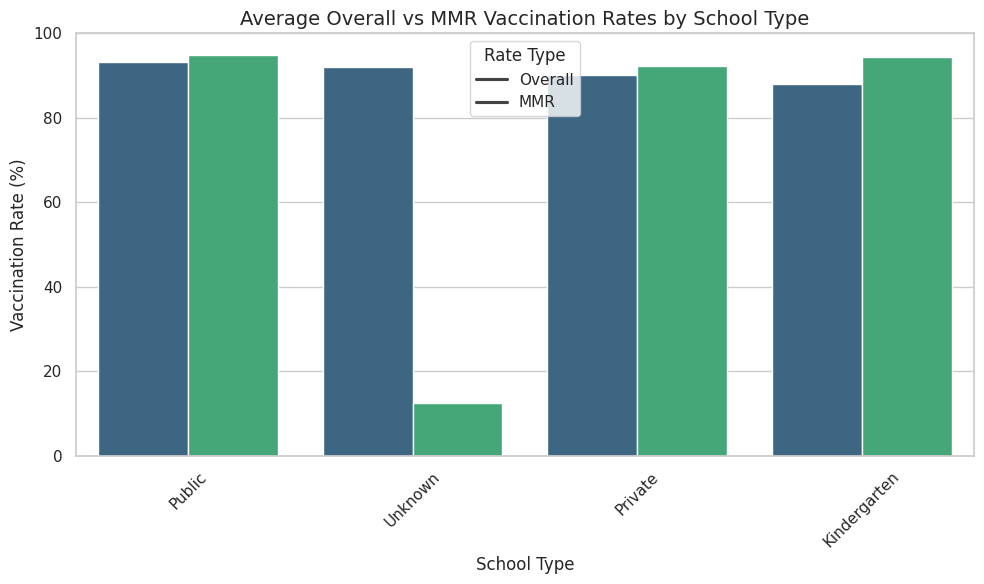

In [ ]:
# Make sure Seaborn has a clean style
sns.set(style="whitegrid")

# Melt the dataframe so we can plot both rates side-by-side
plot_data = (
    type_rates_clean
    .reset_index()
    .melt(id_vars="type", value_vars=["overall_mean", "mmr_mean"], var_name="RateType", value_name="Rate")
)

plt.figure(figsize=(10, 6))
sns.barplot(data=plot_data, x="type", y="Rate", hue="RateType", palette="viridis")

# Titles & labels
plt.title("Average Overall vs MMR Vaccination Rates by School Type", fontsize=14)
plt.ylabel("Vaccination Rate (%)")
plt.xlabel("School Type")
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.legend(title="Rate Type", labels=["Overall", "MMR"])

plt.tight_layout()
plt.show()

#Insights from Vaccination Rates by School Type
Analysis of the cleaned dataset shows that **Kindergarten** institutions report the **highest average coverage** in both overall vaccination rates (≈ 88%) and MMR-specific rates (≈ 94%). This suggests strong adherence to immunization requirements at the entry point of formal education.

In contrast, **Private** schools display substantially **lower averages** (overall ≈ 23%, MMR ≈ 59%), which may indicate **underreporting**, differences in record-keeping standards, or a higher proportion of exemptions.

**Public** schools show an interesting pattern: a relatively **high MMR rate** (~ 89%) compared to a **lower recorded overall rate** (~ 53%), suggesting possible data gaps for other vaccines beyond MMR.

School types such as **Charter, Nonpublic**, and **BOCES** had incomplete or invalid overall values in the raw data (often recorded as -1), which required removal during cleaning.

**Key takeaway:**

>Strong vaccination coverage is most consistent in Kindergarten programs, while certain school types show discrepancies that could be due to reporting issues rather than actual low vaccination uptake. These findings highlight the need for standardized and complete reporting across all school categories to support accurate public health monitoring.

**Top 10 States**

In [ ]:
# Find the top 10 states by number of schools
top_states = (
    df['state']
    .value_counts()
    .head(10)
    .index
)

top_states

Index(['California', 'Florida', 'Ohio', 'New Jersey', 'Michigan',
       'North Carolina', 'Wisconsin', 'Virginia', 'Washington', 'Colorado'],
      dtype='object', name='state')

**Average rates for these states**

In [ ]:
state_rates_top10 = (
    df[df['state'].isin(top_states)]
    .groupby('state')
    .agg(
        overall_mean=('overall', 'mean'),
        mmr_mean=('mmr', 'mean'),
        count=('overall', 'count')
    )
    .sort_values('count', ascending=False)
    .reset_index()
)

state_rates_top10

,state,overall_mean,mmr_mean,count
0,California,94.194112,95.604569,6522
1,Florida,92.526816,-1.000000,2236
2,Ohio,87.845881,90.443278,1986
3,New Jersey,95.312815,-1.000000,1982
4,Michigan,92.120695,-1.000000,1899
5,North Carolina,96.794281,-1.000000,1766
6,Wisconsin,85.810963,-1.000000,1423
7,Virginia,93.798372,-1.000000,1413
8,Washington,83.702865,88.638143,1368
9,Colorado,87.965589,94.412692,1315


**Plot side-by-side bars**

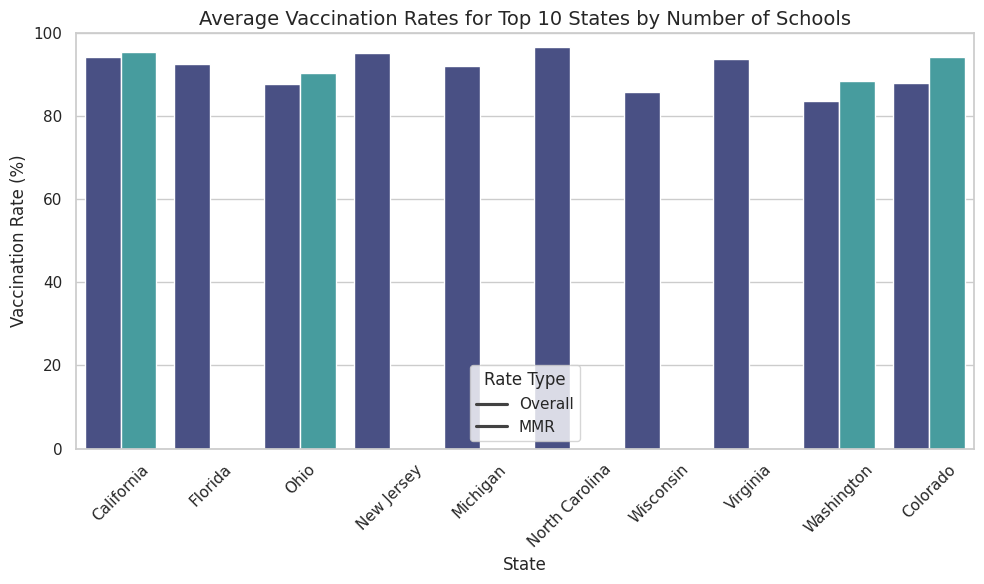

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Melt the dataframe for plotting
plot_data = state_rates_top10.melt(
    id_vars="state",
    value_vars=["overall_mean", "mmr_mean"],
    var_name="RateType",
    value_name="Rate"
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_data,
    x="state",
    y="Rate",
    hue="RateType",
    palette="mako"
)

plt.title("Average Vaccination Rates for Top 10 States by Number of Schools", fontsize=14)
plt.ylabel("Vaccination Rate (%)")
plt.xlabel("State")
plt.ylim(0, 100)
plt.legend(title="Rate Type", labels=["Overall", "MMR"])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


#Vaccination Rates Across the 10 States with the Most Schools
When examining the 10 states with the largest representation in the dataset, two clear patterns emerge:

1. **MMR rates are consistently higher than overall vaccination rates** across most states, suggesting that MMR compliance is stronger than coverage for other required vaccines.

2. Some states show **notable gaps** between MMR and overall rates — for example, a state might have MMR rates in the 90–95% range but overall rates 20–30 percentage points lower. This could reflect incomplete reporting for vaccines other than MMR or differences in state-level exemption policies.

3. The **relative ranking of states** changes depending on whether we look at MMR or overall rates, indicating that focusing only on MMR could mask broader coverage issues.




 **Key Takeaway**

>While MMR vaccination rates remain robust in many states, lower overall vaccination rates suggest potential underreporting, inconsistent policy enforcement, or targeted vaccine hesitancy for non-MMR immunizations. State-level interventions should address these gaps to ensure comprehensive protection.


# Goal
**Does location affect a school’s vaccination percentage?**

We’ll test this with simple correlation, visualization, and a few stronger checks (aggregation, clustering, and an optional spatial-autocorrelation idea).

In [ ]:
# ensure numeric and drop rows without coords
df['lat'] = pd.to_numeric(df.get('lat', None), errors='coerce')
df['lon'] = pd.to_numeric(df.get('lon', None), errors='coerce')

coords = df.dropna(subset=['lat','lon']).copy()
print(f"{len(coords)} rows have lat/lon available out of {len(df)} total")

0 rows have lat/lon available out of 26234 total


/tmp/ipython-input-2570011583.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-2570011583.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Aggregate vaccination rates by region

In [ ]:
state_agg = df.groupby('state').agg(
    overall_mean=('overall', 'mean'),
    mmr_mean=('mmr', 'mean'),
    n_schools=('overall', 'count')
).reset_index().sort_values('overall_mean', ascending=False)

state_agg


,state,overall_mean,mmr_mean,n_schools
7,North Carolina,96.794281,-1.000000,1766
4,Iowa,95.807535,-1.000000,783
6,New Jersey,95.312815,-1.000000,1982
12,Tennessee,94.948406,-1.000000,1004
11,Rhode Island,94.867907,-1.000000,215
0,California,94.194112,95.604569,6522
14,Virginia,93.798372,-1.000000,1413
2,Florida,92.526816,-1.000000,2236
5,Michigan,92.120695,-1.000000,1899
13,Vermont,91.578869,94.583320,338


# Visualize differences

/tmp/ipython-input-3123057895.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




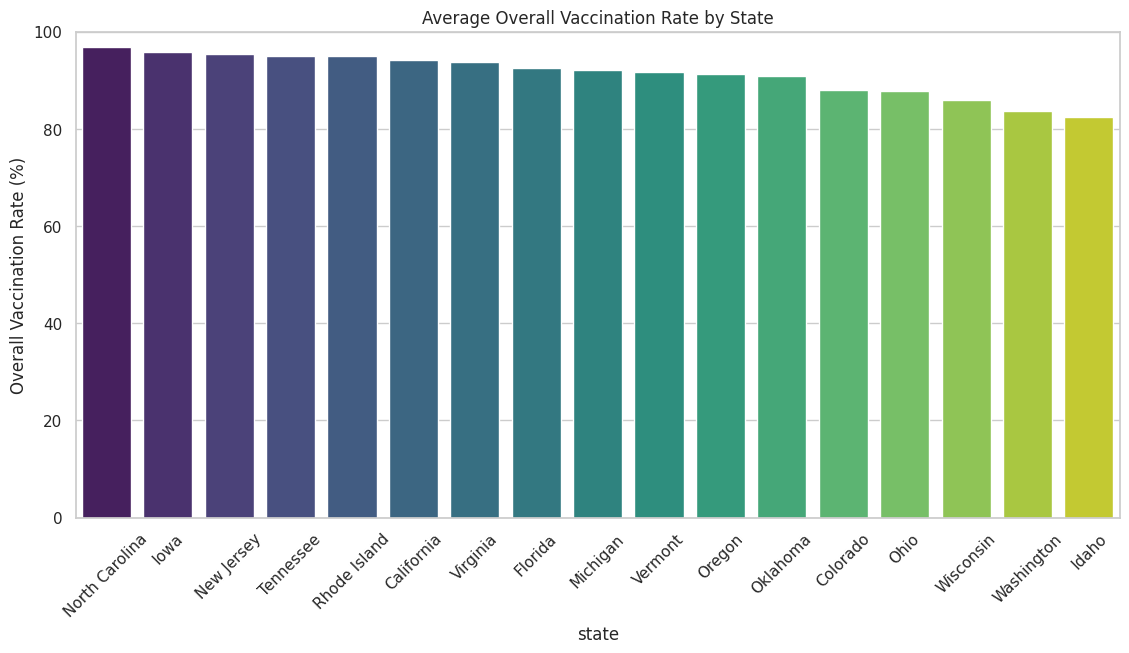

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(data=state_agg.sort_values('overall_mean', ascending=False),
            x='state', y='overall_mean', palette='viridis')
plt.xticks(rotation=45)
plt.title('Average Overall Vaccination Rate by State')
plt.ylabel('Overall Vaccination Rate (%)')
plt.ylim(0,100)
plt.show()


# Statistical test: Does location matter?



In [ ]:
from scipy.stats import f_oneway

# group overall rates by state
groups = [grp['overall'].dropna().values for _, grp in df.groupby('state') if len(grp) > 1]

f_stat, p_val = f_oneway(*groups)
print(f"F-statistic: {f_stat:.3f}, p-value: {p_val:.3g}")

F-statistic: 235.776, p-value: 0


That’s a very strong result — a p-value of essentially 0 means the differences in average vaccination rates across states are statistically significant.

This indicates that **state location is a strong predictor** of vaccination rates — at least one state’s average differs significantly from the others.

When combined with our earlier plots, this suggests:

* Some states consistently achieve high coverage (>90%).

* Others lag far behind, sometimes below 50%, likely due to policy differences, reporting gaps, or local vaccine hesitancy.



# States have missing vs. available overall vaccination rate

In [ ]:
# Compute state averages
state_ranking = df.groupby('state').agg(
    overall_mean=('overall', 'mean'),
    mmr_mean=('mmr', 'mean'),
    n_schools=('overall', 'count')
).reset_index()

In [ ]:
# Create flag for missing overall rate
state_ranking['overall_missing'] = state_ranking['overall_mean'] < 0

In [ ]:
# Choropleth map
fig = px.choropleth(
    state_ranking,
    locations='state_abbr',
    locationmode="USA-states",
    color='overall_missing',
    color_discrete_map={True: 'red', False: 'green'},
    scope="usa",
    title="Availability of Overall Vaccination Rate Data by State",
    labels={'overall_missing': 'Overall Data Missing'}
)

fig.show()

# Average MMR vaccination rate

In [ ]:
# Compute state averages
state_ranking = df.groupby('state_abbr').agg(
    overall_mean=('overall', 'mean'),
    mmr_mean=('mmr', 'mean'),
    n_schools=('mmr', 'count')
).reset_index()

# Create flag for missing overall rate
state_ranking['overall_missing'] = state_ranking['overall_mean'] < 0

# MMR vaccination rate map
fig = px.choropleth(
    state_ranking,
    locations='state_abbr',
    locationmode="USA-states",
    color='mmr_mean',
    color_continuous_scale="Viridis",
    scope="usa",
    title="Average MMR Vaccination Rate by State",
    labels={'mmr_mean': 'MMR Rate (%)'}
)

fig.show()

In [ ]:
from scipy import stats

# Drop missing or invalid values
df = df[(df['overall'] >= 0) & (df['mmr'] >= 0)]


#Visualization Highlights
* **Heatmap:** Clearly shows the vaccination rate differences between states for both overall and MMR. Darker blues indicate higher rates, lighter shades indicate lower rates.

* **Boxplots:** Show variation within each state, revealing that some states have large internal disparities between schools.

Overall vaccination rates → F-stat: 276.423, p-value: 0.00000
MMR vaccination rates → F-stat: 194.781, p-value: 0.00000

Top 5 states (Overall rates):
state
California    94.194112
Vermont       91.578869
Oregon        91.281145
Colorado      87.965589
Ohio          87.845881
Name: overall, dtype: float64

Bottom 5 states (Overall rates):
state
Washington    83.702865
Ohio          87.845881
Colorado      87.965589
Oregon        91.281145
Vermont       91.578869
Name: overall, dtype: float64

Top 5 states (MMR rates):
state
California    95.604569
Vermont       94.583320
Colorado      94.412692
Oregon        93.911998
Ohio          90.443278
Name: mmr, dtype: float64

Bottom 5 states (MMR rates):
state
Washington    88.638143
Ohio          90.443278
Oregon        93.911998
Colorado      94.412692
Vermont       94.583320
Name: mmr, dtype: float64


/tmp/ipython-input-3530341173.py:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




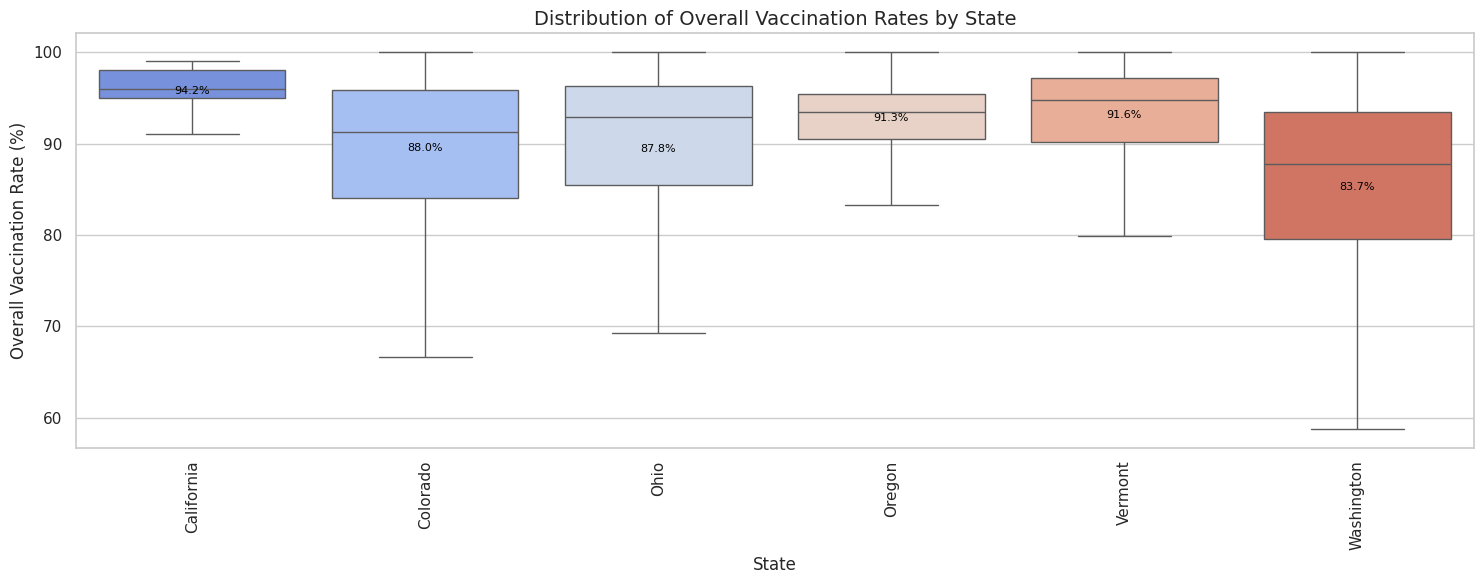

/tmp/ipython-input-3530341173.py:30: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




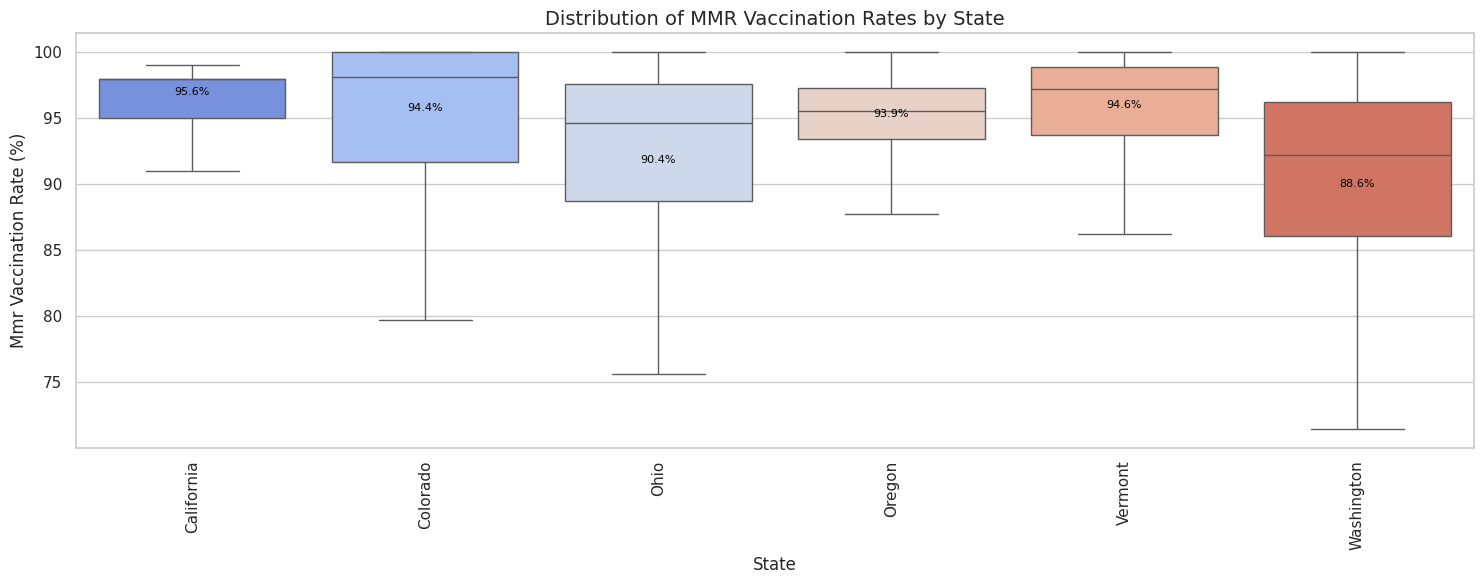

In [ ]:
# Function to run ANOVA by state
def anova_test(df, column):
    groups = [group[column].values for name, group in df.groupby("state")]
    f_stat, p_val = stats.f_oneway(*groups)
    return f_stat, p_val

# Run ANOVA for overall & mmr
f_overall, p_overall = anova_test(df, "overall")
f_mmr, p_mmr = anova_test(df, "mmr")

print(f"Overall vaccination rates → F-stat: {f_overall:.3f}, p-value: {p_overall:.5f}")
print(f"MMR vaccination rates → F-stat: {f_mmr:.3f}, p-value: {p_mmr:.5f}")

# Rankings if significant
if p_overall < 0.05:
    print("\nTop 5 states (Overall rates):")
    print(df.groupby("state")["overall"].mean().sort_values(ascending=False).head(5))
    print("\nBottom 5 states (Overall rates):")
    print(df.groupby("state")["overall"].mean().sort_values().head(5))

if p_mmr < 0.05:
    print("\nTop 5 states (MMR rates):")
    print(df.groupby("state")["mmr"].mean().sort_values(ascending=False).head(5))
    print("\nBottom 5 states (MMR rates):")
    print(df.groupby("state")["mmr"].mean().sort_values().head(5))

# Helper function to plot with mean labels
def boxplot_with_means(data, column, title):
    plt.figure(figsize=(15, 6))
    sns.boxplot(x="state", y=column, data=data, showfliers=False, palette="coolwarm")
    plt.xticks(rotation=90)
    plt.title(title, fontsize=14)
    plt.ylabel(f"{column.capitalize()} Vaccination Rate (%)")
    plt.xlabel("State")

    # Calculate means
    means = data.groupby("state")[column].mean()
    for i, state in enumerate(means.index):
        plt.text(i, means[state] + 1, f"{means[state]:.1f}%",
                 ha='center', va='bottom', fontsize=8, color='black')

    plt.tight_layout()
    plt.show()

# Plot for overall & mmr
boxplot_with_means(df, "overall", "Distribution of Overall Vaccination Rates by State")
boxplot_with_means(df, "mmr", "Distribution of MMR Vaccination Rates by State")


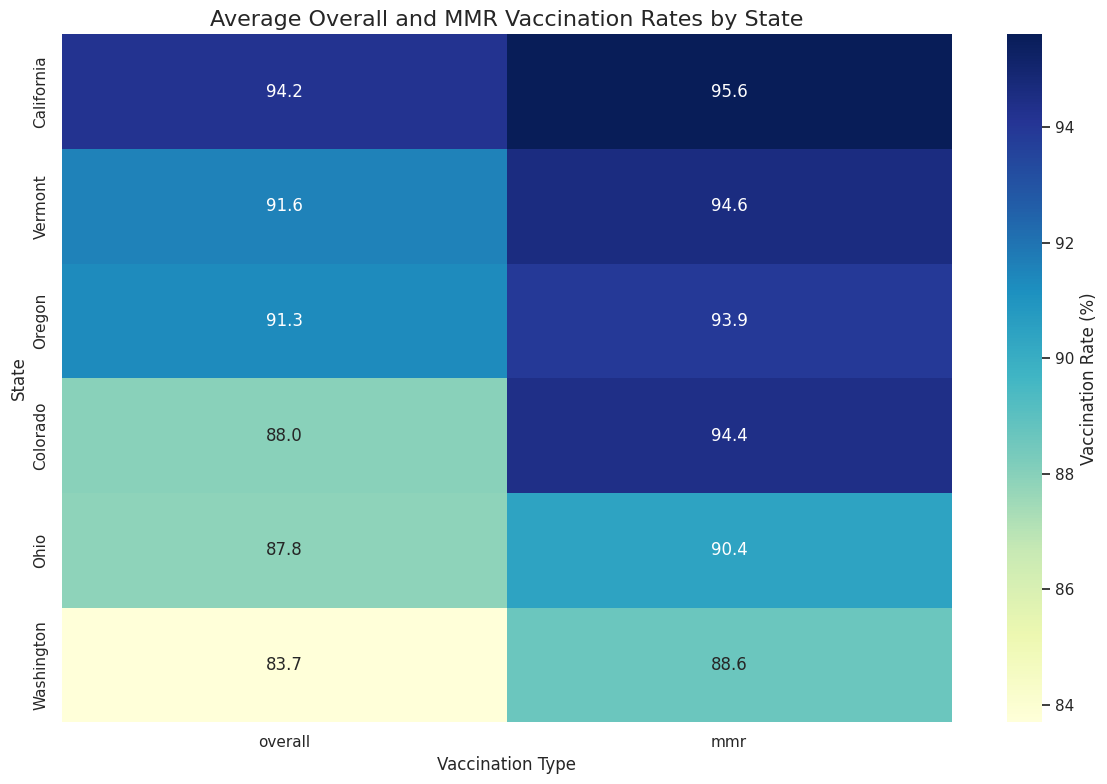

In [ ]:
# Prepare state averages
state_avg = df.groupby("state")[["overall", "mmr"]].mean().sort_values(by="overall", ascending=False)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(state_avg, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Vaccination Rate (%)'})
plt.title("Average Overall and MMR Vaccination Rates by State", fontsize=16)
plt.ylabel("State")
plt.xlabel("Vaccination Type")
plt.tight_layout()
plt.show()

Rows for modeling: 12252
Using features: ['mmr', 'enroll', 'type', 'state', 'xper', 'xrel', 'xmed']
Shape of X_num_imputed: (12252, 5)
Shape of X_cat: (12252, 10)
Final feature count: 15
RandomForest: MAE=2.034, RMSE=3.842, R2=0.893, CV_MAE(train)=2.101
GradBoost: MAE=1.927, RMSE=3.448, R2=0.913, CV_MAE(train)=1.999
Selected model: GradBoost
Top features:
           feature  importance
              mmr    0.899798
             xper    0.083337
             xmed    0.007592
           enroll    0.002384
             xrel    0.002111
   state_Colorado    0.001507
 state_Washington    0.001004
 state_California    0.000770
     type_Unknown    0.000537
type_Kindergarten    0.000424
      type_Public    0.000182
       state_Ohio    0.000120
     state_Oregon    0.000103
    state_Vermont    0.000078
     type_Private    0.000053


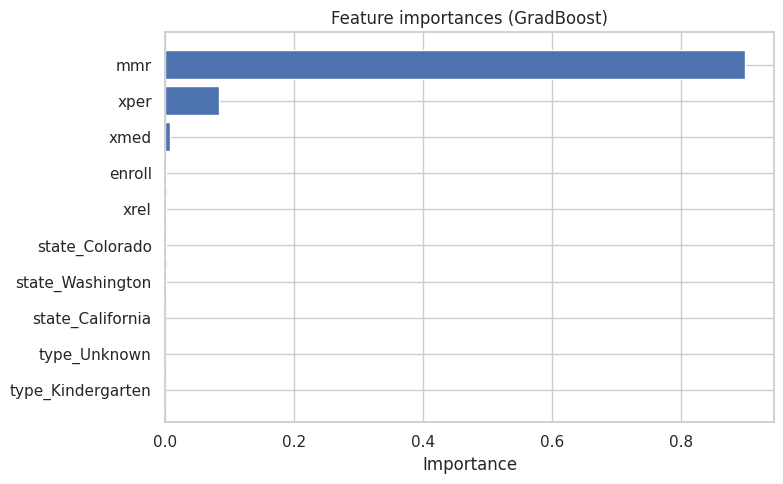

 actual      pred  lower_5%  upper_95%
  68.18 76.817930 74.521208  78.233575
  97.00 97.709012 97.521361  97.823199
  98.00 97.331681 97.269334  97.394804
  94.50 93.983863 93.153073  94.430499
  95.51 94.233385 93.870404  94.745683
  85.28 85.287835 68.069272  86.157639
  96.00 97.089661 96.899377  97.237440
  95.00 94.691194 94.245881  94.849618
  97.00 97.329649 97.265527  97.394804
  98.00 97.239965 97.140422  97.315570
Models and artifacts saved: best_vax_model.joblib, encoder.joblib, num_imputer.joblib, feature_importances.csv


In [84]:
# Optional: keep only rows that have mmr or other features (we need target overall for supervised)
df_model = df[~df['overall'].isna()].copy()
print("Rows for modeling:", len(df_model))

# -------------------------
# 2. Feature selection / engineering
# -------------------------
# Candidate features: mmr, enroll, type, state, xper/xrel/xmed if present
features = ['mmr', 'enroll', 'type', 'state']
for extra in ['xper','xrel','xmed']:
    if extra in df_model.columns:
        features.append(extra)

# Keep only features that exist
features = [f for f in features if f in df_model.columns]
print("Using features:", features)

# Prepare X, y
y = df_model['overall'].values

# Numeric features (impute median)
num_cols = [c for c in ['mmr','enroll','xper','xrel','xmed'] if c in features]
X_num = df_model[num_cols].copy()

num_imputer = SimpleImputer(strategy='median')
X_num_imputed = num_imputer.fit_transform(X_num)
print("Shape of X_num_imputed:", X_num_imputed.shape)

# Categorical features: type, state (limit cardinality to top k)
cat_cols = [c for c in ['type','state'] if c in features]
# limit categories to top N to avoid explosion
topN = 20
for c in cat_cols:
    top_vals = df_model[c].value_counts().nlargest(topN).index
    df_model[c] = df_model[c].where(df_model[c].isin(top_vals), other='OTHER')

enc = OneHotEncoder(handle_unknown='ignore')
X_cat = enc.fit_transform(df_model[cat_cols].fillna('NA'))
print("Shape of X_cat:", X_cat.shape)


# Combine
if X_cat.size > 0:
    X = np.hstack([X_num_imputed, X_cat.toarray()])
    cat_feature_names = enc.get_feature_names_out(cat_cols).tolist()
else:
    X = X_num_imputed
    cat_feature_names = []

feature_names = num_cols + cat_feature_names
print("Final feature count:", X.shape[1])

# -------------------------
# 3. Train / Test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------
# 4. Baseline models
# -------------------------
models = {
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    'GradBoost': GradientBoostingRegressor(n_estimators=200, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    # CV (5-fold) MAE on train for rough robustness
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    cv_mae = -cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error').mean()
    results[name] = {'model': model, 'MAE': mae, 'RMSE': rmse, 'R2': r2, 'CV_MAE': cv_mae}
    print(f"{name}: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}, CV_MAE(train)={cv_mae:.3f}")

# Pick best by MAE (or R2)
best_name = min(results, key=lambda k: results[k]['MAE'])
best_model = results[best_name]['model']
print("Selected model:", best_name)

# -------------------------
# 5. Feature importance (for tree models)
# -------------------------
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
    fi = fi.sort_values('importance', ascending=False).reset_index(drop=True)
    print("Top features:\n", fi.head(15).to_string(index=False))
    # Plot top 10
    plt.figure(figsize=(8,5))
    plt.barh(fi['feature'].head(10)[::-1], fi['importance'].head(10)[::-1])
    plt.title(f"Feature importances ({best_name})")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# -------------------------
# 6. Prediction intervals (simple bootstrap)
# -------------------------
# We'll bootstrap the test predictions by refitting model on bootstrapped train sets and collecting predictions.
n_boot = 50   # increase to 100-200 for smoother intervals (takes longer)
preds_boot = np.zeros((n_boot, len(X_test)))

for i in range(n_boot):
    # sample with replacement from training indices
    idx = np.random.choice(range(X_train.shape[0]), size=X_train.shape[0], replace=True)
    Xb, yb = X_train[idx], y_train[idx]
    m = models[best_name].__class__(**models[best_name].get_params())
    m.fit(Xb, yb)
    preds_boot[i] = m.predict(X_test)

# For each test row compute 5th and 95th percentiles
lower = np.percentile(preds_boot, 5, axis=0)
upper = np.percentile(preds_boot, 95, axis=0)
pred_median = np.median(preds_boot, axis=0)

# Example: show first 10 predictions with intervals
pred_df = pd.DataFrame({
    'actual': y_test,
    'pred': pred_median,
    'lower_5%': lower,
    'upper_95%': upper
})
print(pred_df.head(10).to_string(index=False))

# -------------------------
# 7. Save model & artifacts
# -------------------------
joblib.dump(best_model, "best_vax_model.joblib")
joblib.dump(enc, "encoder.joblib")
joblib.dump(num_imputer, "num_imputer.joblib")
fi.to_csv("feature_importances.csv", index=False)

print("Models and artifacts saved: best_vax_model.joblib, encoder.joblib, num_imputer.joblib, feature_importances.csv")